# Training the model for the Adult dataset

In [1]:
import pandas as pd
import numpy as np
import shap
def adult(display=False, n_points=None):
    """ Return the Adult census data in a nice package. """
    dtypes = [
        ("Age", "float32"), ("Workclass", "category"), ("fnlwgt", "float32"),
        ("Education", "category"), ("Education-Num", "float32"), ("Marital Status", "category"),
        ("Occupation", "category"), ("Relationship", "category"), ("Race", "category"),
        ("Sex", "category"), ("Capital Gain", "float32"), ("Capital Loss", "float32"),
        ("Hours per week", "float32"), ("Country", "category"), ("Target", "category")
    ]
    raw_data = pd.read_csv(
        "adult.data",
        names=[d[0] for d in dtypes],
        na_values="?",
        dtype=dict(dtypes)
    )

    if n_points is not None:
        raw_data = shap.utils.sample(raw_data, n_points, random_state=0)

    data = raw_data.drop(["Education"], axis=1)  # redundant with Education-Num
    filt_dtypes = list(filter(lambda x: x[0] not in ["Target", "Education"], dtypes))
    data["Target"] = data["Target"] == " >50K"
    rcode = {
        "Not-in-family": 0,
        "Unmarried": 1,
        "Other-relative": 2,
        "Own-child": 3,
        "Husband": 4,
        "Wife": 5
    }
    for k, dtype in filt_dtypes:
        if dtype == "category":
            if k == "Relationship":
                data[k] = np.array([rcode[v.strip()] for v in data[k]])
            else:
                data[k] = data[k].cat.codes

    if display:
        return raw_data.drop(["Education", "Target", "fnlwgt"], axis=1), data["Target"].values
    return data.drop(["Target", "fnlwgt"], axis=1), data["Target"].values


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import shap
from sklearn.model_selection import train_test_split
try:
    X, y = adult()
except:
    X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np 

# Define the categorical and numerical features
cats = ['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
nums = ['Age', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']

# Define the column transformer 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cats), 
        ('num', StandardScaler(), nums)
    ])

# Define the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000))
]) 

# Fit the pipeline to the training data
model.fit(X_train, y_train)
X_sub = shap.sample(X_train, 100)
ex = shap.Explainer(model.predict_proba, X_sub)
shap_values = ex(X_test.iloc[0:100])

Permutation explainer: 101it [00:56,  1.76it/s]                         


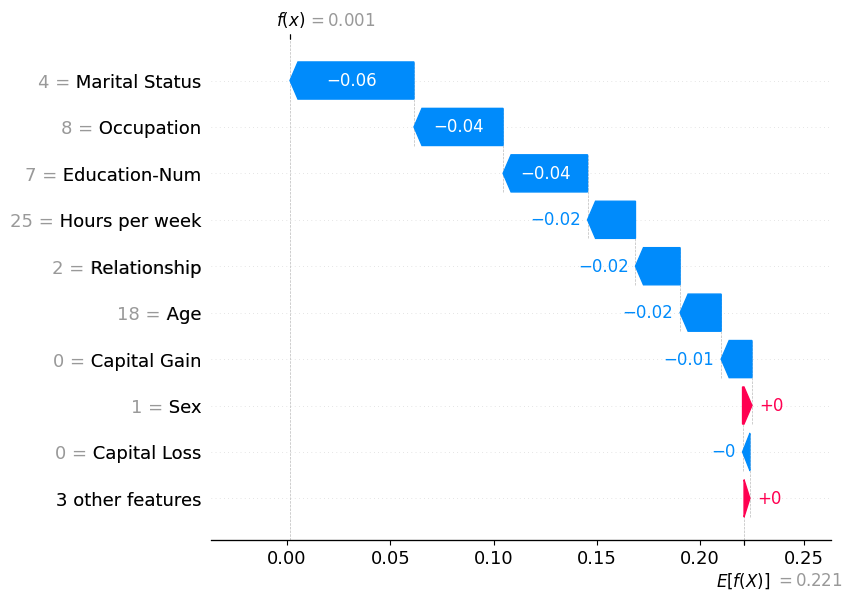

In [4]:
class_index = 1
data_index = 1
shap.plots.waterfall(shap_values[data_index,:,class_index])

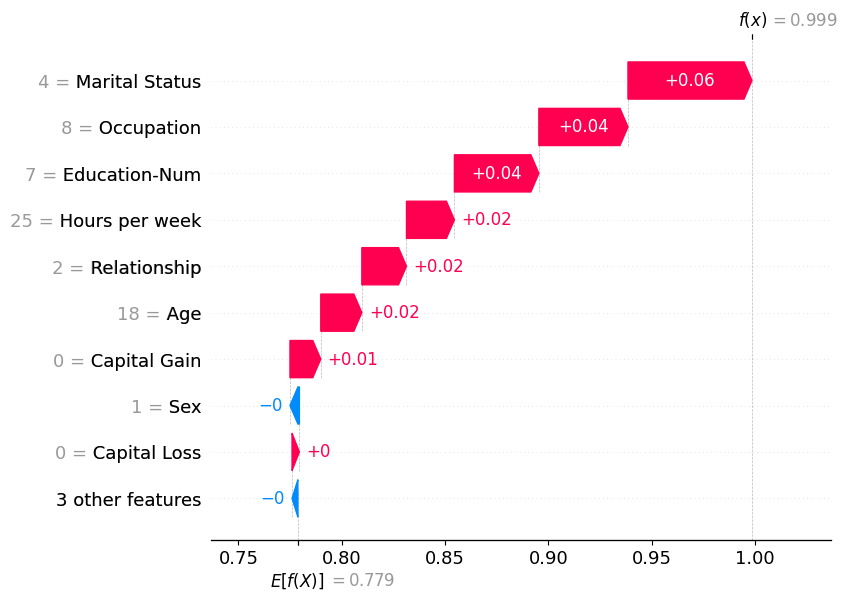

In [6]:
class_index = 0
shap.plots.waterfall(shap_values[data_index,:,class_index])

# Alternatives to the waterfall plot

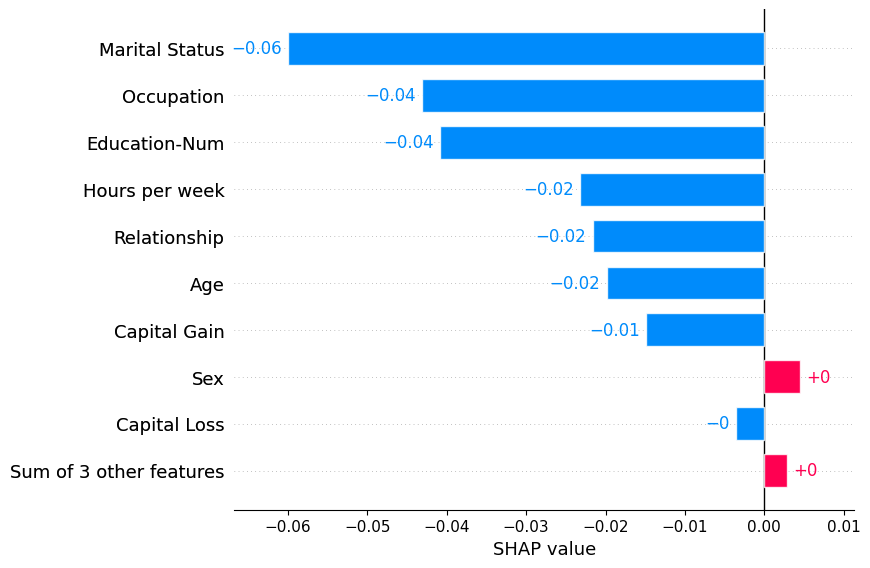

In [7]:
# First, reset class_index
class_index=1
shap.plots.bar(shap_values[data_index,:,class_index])

In [8]:
shap.initjs()
shap.plots.force(shap_values[data_index,:,class_index])

# Interpreting log odds

Permutation explainer: 101it [00:53,  1.72it/s]                         


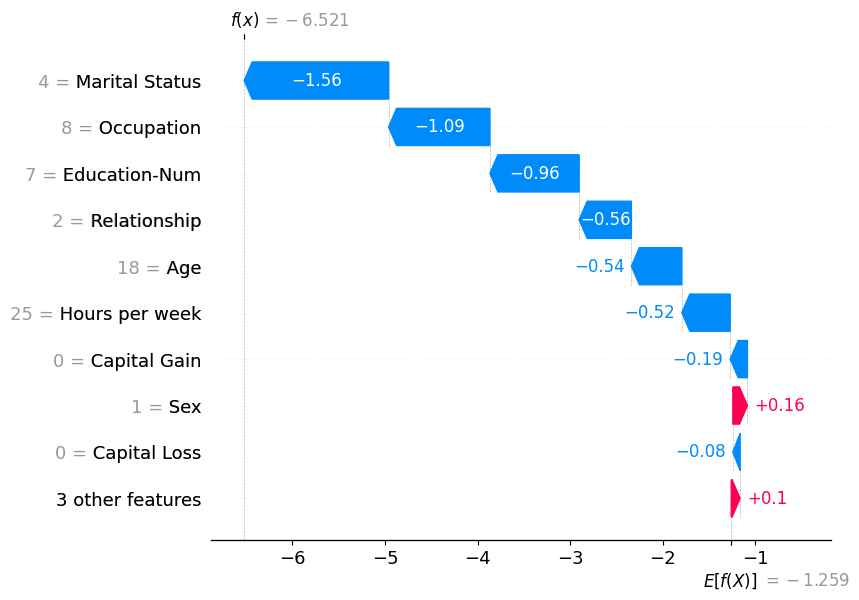

In [9]:
ex_logit = shap.Explainer(model.predict_proba, X_sub, link=shap.links.logit)
sv_logit = ex_logit(X_test.iloc[0:100])
shap.plots.waterfall(sv_logit[data_index,:,class_index])

# Understanding the data globally

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


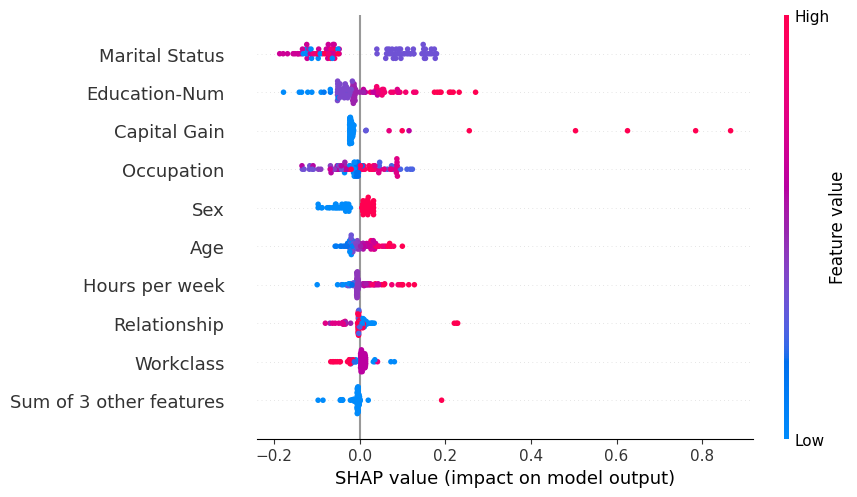

In [10]:
shap.plots.beeswarm(shap_values[:,:,class_index])

# Clustering SHAP values

In [11]:
shap.plots.force(sv_logit[0:20:,:,0])

# The heatmap plot

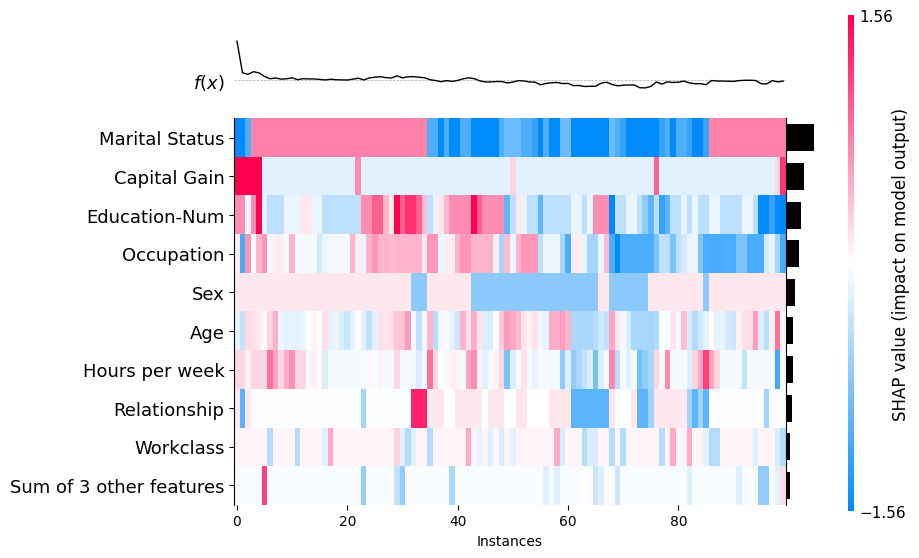

In [12]:
shap.plots.heatmap(sv_logit[:,:,class_index])